In [44]:
import os

import numpy as np

import torch
import torchvision
from torchvision.io import read_image

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import ignite

from piq import BRISQUELoss, TVLoss, brisque, ssim, psnr, tv

import cv2

import matplotlib.pyplot as plt

from utils import loss_history, plot_history

%matplotlib inline

In [36]:
path_img = './data/RealSR(V3)/canon/train/2'
images_lr = []
images_hr = []

for filename in os.listdir(path_img):
    if filename.find('LR')>0:
        images_lr.append(read_image(os.path.join(path_img, filename)).type(torch.FloatTensor)/255.)
    else:
        images_hr.append(read_image(os.path.join(path_img, filename)).type(torch.FloatTensor)/255.)

path_img = './data/RealSR(V3)/canon/test/2'
images_lr_test = []
images_hr_test = []

for filename in os.listdir(path_img):
    if filename.find('LR')>0:
        images_lr_test.append(read_image(os.path.join(path_img, filename))/255.)
    else:
        images_hr_test.append(read_image(os.path.join(path_img, filename))/255.)
        

In [37]:
images_lr_downscales = []
scale = 2
for image in images_lr:
    resize = torchvision.transforms.Resize((int(image.shape[1]/scale), int(image.shape[2]/scale)))
    image_downscale = resize(image)
    images_lr_downscales.append(image_downscale)
    
images_lr_downscales_test = []
scale = 2
for image in images_lr_test:
    resize = torchvision.transforms.Resize((int(image.shape[1]/scale), int(image.shape[2]/scale)))
    image_downscale = resize(image)
    images_lr_downscales_test.append(image_downscale)    

C:\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


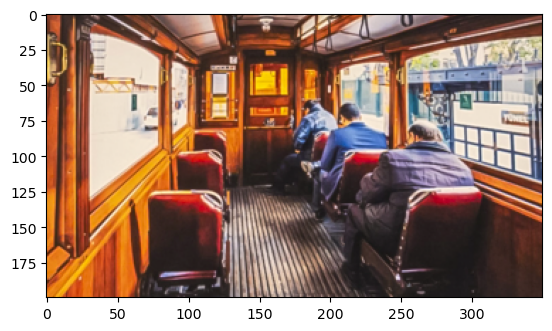

In [4]:
plt.imshow(images_lr_downscales[0].permute(1,2,0))

In [4]:
class images_dataset(Dataset):
    def __init__(self, data_source, data_target):
        self.data_source = data_source
        self.data_target = data_target
        
    def __len__(self):
        return len(self.data_source)
    
    def __getitem__(self, index):
        data_source = self.data_source[index]
        data_target = self.data_target[index]
        return data_source, data_target

In [5]:
def collate_fn(batch):
    data_source = torch.LongTensor([item[0] for item in batch])
    data_target = torch.LongTensor([item[1] for item in batch])
    return data_source, data_target

In [6]:
ds_lrdown2lr_train = images_dataset(images_lr_downscales, images_lr)
ds_lrdown2lr_test = images_dataset(images_lr_downscales_test, images_lr_test)

BATCH_SIZE = 1

dl_lrdown2lr_train = DataLoader(ds_lrdown2lr_train,
                               batch_size=BATCH_SIZE,
                               shuffle=True)#,
                               #num_workers=0,
                               #collate_fn=collate_fn)
dl_lrdown2lr_test = DataLoader(ds_lrdown2lr_test,
                               batch_size=BATCH_SIZE,
                               shuffle=True)#,
                               #num_workers=0,
                               #collate_fn=collate_fn)
dl_lrdown2lr = {'train': dl_lrdown2lr_train, 'test': dl_lrdown2lr_test}

In [7]:
class conv_block(nn.Module):
    def __init__(self, *args, **kwargs):
        super(conv_block, self).__init__()
        self.conv1 = nn.Conv2d(*args, **kwargs)
        self.bn = nn.BatchNorm2d(kwargs['out_channels'])
        self.activation = nn.GELU()
        
    def forward(self, x):
        x_input = x
        x = self.conv1(x_input)
        x = self.bn(x)
        x = self.activation(x)
        out = x + x_input
        return out
        

class lrdown2lr(nn.Module):
    def __init__(self, scale=2, n_blocks=8, channels=64):
        super().__init__()
        
        self.n_blocks = n_blocks
        self.channels = channels
        
        self.upscale = nn.Upsample(scale_factor=2)
        self.conv_in = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=channels, kernel_size=3, padding='same'),
            nn.GELU()
        )
        self.conv_inner_blocks = nn.ModuleList(conv_block(in_channels=channels,
                                     out_channels=channels,
                                     kernel_size=3,
                                     padding='same') for n in range(n_blocks))
        self.conv_out = nn.Conv2d(in_channels=channels, out_channels=3, kernel_size=3, padding='same')
    
    def forward(self, x):
        x_input = x
        x = self.upscale(x.type(torch.FloatTensor)).to(device)
        x = self.conv_in(x)
        for conv_inner in self.conv_inner_blocks:
            x = conv_inner(x)
        x = self.conv_out(x)
        out = x
        
        return out
        
        
#    def conv_block(self, channels_in, channels_out, *args, **kwargs):
#        return nn.Sequential(
#            nn.Conv2d(channels_in, channels_out, *args, **kwargs),
#            nn.BatchNorm2d(channels_out),
#            nn.GELU(),

In [8]:
class torch_trainer():
    
    def __init__(self, model, criterion, optimizer, epochs, dataloader, device='cuda', scheduler=None):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.dataloader = dataloader
        self.device = device
        self.history = loss_history()
        
    
        
    def train(self):

        self.history.clear()
        loss = 0
        val_loss = 0

        for epoch in range(self.epochs):

            epoch_loss = []
            epoch_val_loss = []
            items = len(self.dataloader['train'])

            self.model.train()
            item=1
            for batch in self.dataloader['train']:
                self.optimizer.zero_grad()
                data = batch[0].to(device)
                preds = self.model(data).type(torch.FloatTensor)
                target = batch[1].to(device).type(torch.FloatTensor)
                loss = self.criterion(preds, target)
                loss.backward()
                epoch_loss.append(loss.numpy(force=True))
                self.optimizer.step()
                print (f'epoch {epoch+1}/{self.epochs}... {item}/{items}: train loss: {loss:.4f}, val_loss: {val_loss:.4f}', end='\r')
                item+=1

            items = len(self.dataloader['test'])
            self.model.eval()
            item=1
            with torch.no_grad():
                for batch in self.dataloader['test']:
                    data = batch[0].to(device)
                    preds = self.model(data)
                    target = batch[1].to(device)
                    val_loss = self.criterion(preds, target)
                    epoch_val_loss.append(val_loss.numpy(force=True))
                    print (f'epoch {epoch+1}/{self.epochs}... {item}/{items}: train loss: {loss:.4f}, val_loss: {val_loss:.4f}', end='\r')
                    item+=1

            if scheduler:
                scheduler.step(loss)
                
            loss = np.array(epoch_loss).mean()
            val_loss = np.array(epoch_val_loss).mean()

            self.history.loss.append(loss)
            self.history.val_loss.append(val_loss)
            lr = optimizer.param_groups[0]["lr"]

            print (f'epoch {epoch+1}/{self.epochs}; train loss: {loss:.4f}, val_loss: {val_loss:.4f}; lr={lr}', end='\n')

        return self.history

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print (device) 

cuda


In [110]:
model = lrdown2lr().to(device)
print(model)

lrdown2lr(
  (upscale): Upsample(scale_factor=2.0, mode='nearest')
  (conv_in): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): GELU(approximate='none')
  )
  (conv_inner_blocks): ModuleList(
    (0-7): 8 x conv_block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): GELU(approximate='none')
    )
  )
  (conv_out): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
)


In [345]:
torch.cuda.empty_cache()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
trainer = torch_trainer(model=model,
                       criterion=criterion,
                       optimizer=optimizer,
                       epochs=20,
                       dataloader=dl_lrdown2lr)
history = trainer.train()

epoch 1/20; train loss: 540.5543, val_loss: 33.4849 13.750900
epoch 2/20; train loss: 28.8777, val_loss: 21.2721 19.10554999
epoch 3/20; train loss: 19.9687, val_loss: 15.9370 19.03522111


KeyboardInterrupt: 

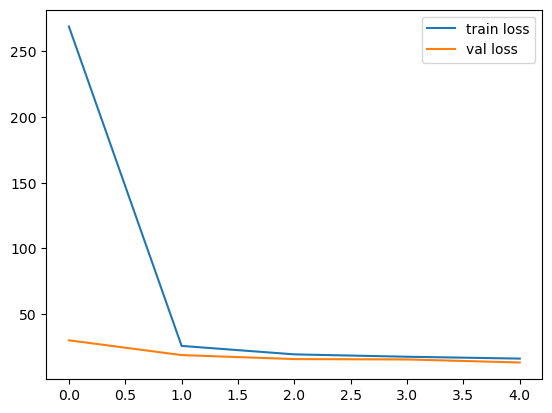

In [13]:
plot_history(history)

In [10]:
def plot_history(history):
    plt.plot(history.loss, label='train loss')
    plt.plot(history.val_loss, label='val loss')
    plt.legend()
    plt.show()

In [68]:
#test = images_lr_downscales[0]
test = images_lr[0]
test = test[None, :]
preds = model(test).type(torch.LongTensor)
img = preds[0].permute(1,2,0).detach()
to_save = (preds[0])/255.
torchvision.utils.save_image(to_save, 'test1.png')
plt.imshow(img)

NameError: name 'model' is not defined

In [16]:
to_save = (preds[0])/255.
torchvision.utils.save_image(to_save, 'test.png')

In [20]:
torch.cuda.empty_cache()

In [59]:
optimizer.param_groups[0]["lr"]

1e-05

In [15]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [25]:
torchvision.utils.save_image(images_lr_downscales[0]/255., 'test2.png')

# deblur

In [138]:
class nn_deblur(nn.Module):
    def __init__(self, n_channels):
        super(nn_deblur, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=(3,3), stride=1, padding='same'),
            nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=(5,5), stride=1, padding='same'),
        )
        self.conv_resc1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1), padding='same')
        
        self.act = nn.GELU()
        
    def forward(self, x):
        x = x.type(torch.cuda.FloatTensor)
        x = self.conv1(x) + self.conv_resc1(x)
        x = self.act(x)
        x = torch.clamp(x, min=0, max=1.)
        return x

In [127]:
class nn_deblur_v2(nn.Module):
    def __init__(self, n_channels):
        super(nn_deblur_v2, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=(3,3), padding='same')
        self.conv2 = nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=(5,5), padding='same')
        
        self.conv_resc = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1), padding='same')
               
        self.act = nn.GELU()
        
    def forward(self, x):
        x0 = x.type(torch.cuda.FloatTensor)
        x = self.conv1(x0) + self.conv2(x0)
        x = x + self.conv_resc(x0)
        x = self.act(x)
        x = torch.clamp(x, min=0, max=1)
        return x

In [128]:
class nn_deblur_v3(nn.Module):
    def __init__(self, n_channels):
        super(nn_deblur_v3, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=(3,3), padding='same')
        self.conv2 = nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=(5,5), padding='same')
        
        self.conv_resc = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1), padding='same')
               
        self.act = nn.GELU()
        
    def forward(self, x):
        x0 = x.type(torch.cuda.FloatTensor)
        x = self.conv1(x0)
        x = self.conv2(x)
        x = x + self.conv_resc(x0)
        x = self.act(x)
        x = torch.clamp(x, min=0, max=1)
        return x

In [106]:
class nn_deblur_tConv(nn.Module):
    def __init__(self, n_channels):
        super(nn_deblur_tConv, self).__init__()
        
        
        
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=3, out_channels=n_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.ConvTranspose2d(in_channels=n_channels, out_channels=3, kernel_size=(5,5), stride=1, padding=2),
        )
        
        self.conv_resc = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1), padding='same')
               
        self.act = nn.GELU()
        
    def forward(self, x):
        x = x.type(torch.cuda.FloatTensor)
        #x = self.conv_in(x)
        x = self.conv(x)
        #x = self.conv_out(x)
        x = x + self.conv_resc(x)
        x = self.act(x)
        x = torch.clamp(x, min=0, max=1.)
        return x

In [72]:
class nn_deblur_v1(nn.Module):
    def __init__(self, n_channels):
        super(nn_deblur_v1, self).__init__()
        
        self.conv_in = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1), stride=1, padding='same')
        
        self.conv3x3 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3), stride=1, padding='same')
        self.conv5x5 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(5,5), stride=1, padding='same')
        self.conv7x7 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(7,7), stride=1, padding='same')
        #self.conv11x11 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(11,11), stride=1, padding='same')
        
        self.conv_out = nn.Conv2d(in_channels=6, out_channels=3, kernel_size=(1,1), stride=1, padding='same')
        self.conv_resc1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1), padding='same')
        
        self.act = nn.GELU()
        
    def forward(self, x):
        x = x.type(torch.cuda.FloatTensor)
        x_input = x
        #x = self.conv_in(x)
        
        x_3x3 = self.conv3x3(x)
        x_5x5 = self.conv5x5(x)
        #x_7x7 = self.conv7x7(x)
        #x_11x11 = self.conv11x11(x)
        
        x = torch.cat((x_3x3, x_5x5), 1) #, x_7x7, x_11x11), 1)

        x = self.conv_out(x) + self.conv_resc1(x_input)
        x = self.act(x)
        x = torch.clamp(x, min=0, max=255)

        return x

In [112]:
ds_deblur_train = images_dataset(images_lr[:1], images_lr[:1])
ds_deblur_test = images_dataset(images_lr_test[:1], images_lr_test[:1])

BATCH_SIZE = 1

dl_deblur_train = DataLoader(ds_deblur_train,
                               batch_size=BATCH_SIZE,
                               shuffle=False)
dl_deblur_test = DataLoader(ds_deblur_test,
                               batch_size=BATCH_SIZE,
                               shuffle=False)

dl_deblur = {'train': dl_deblur_train, 'test': dl_deblur_test}

ds_deblur_withscale = images_dataset(images_lr_downscales[:10], images_lr[:10])
dl_deblur_withscale = DataLoader(ds_deblur_withscale,
                               batch_size=BATCH_SIZE,
                               shuffle=False)

dl_deblur_withscale = {'train': dl_deblur, 'test': dl_deblur_test}

In [143]:
model_deblur = nn_deblur(3).to(device)
print(model_deblur)

def loss_brisque(y_pred, y_true):
    loss = BRISQUELoss(data_range=1)
    loss = loss(y_pred) #+ 0.01*nn.L1Loss()(y_pred, y_true)

    return loss


def loss_tv(y_pred, y_true):
    loss = TVLoss()(y_pred)
    loss = 10000/loss + 0.01*nn.L1Loss()(y_pred, y_true)
    return loss

criterion_deblur = loss_tv
optimizer = torch.optim.Adamax(model_deblur.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=3,min_lr=1e-7)
trainer = torch_trainer(model=model_deblur,
                       criterion=criterion_deblur,
                       optimizer=optimizer,
                       epochs=3000,
                       dataloader=dl_deblur)
history = trainer.train()


nn_deblur(
  (conv1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=same)
  )
  (conv_resc1): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (act): GELU(approximate='none')
)
epoch 1/3000; train loss: 296.6364, val_loss: 420.2482; lr=0.01
epoch 2/3000; train loss: 198.3103, val_loss: 309.8167; lr=0.01
epoch 3/3000; train loss: 169.5399, val_loss: 262.5634; lr=0.01
epoch 4/3000; train loss: 157.6217, val_loss: 233.2353; lr=0.01
epoch 5/3000; train loss: 147.0031, val_loss: 213.8528; lr=0.01
epoch 6/3000; train loss: 138.2912, val_loss: 202.1285; lr=0.01
epoch 7/3000; train loss: 129.5676, val_loss: 193.4081; lr=0.01
epoch 8/3000; train loss: 122.4768, val_loss: 189.1688; lr=0.01
epoch 9/3000; train loss: 117.2955, val_loss: 186.8657; lr=0.01
epoch 10/3000; train loss: 113.4568, val_loss: 183.7869; lr=0.01
epoch 11/3000; train loss: 109.8740, val_loss: 180.4431; lr=0.01


epoch 126/3000; train loss: 39.2753, val_loss: 68.4578; lr=0.01
epoch 127/3000; train loss: 39.2117, val_loss: 68.3327; lr=0.01
epoch 128/3000; train loss: 39.1488, val_loss: 68.2085; lr=0.01
epoch 129/3000; train loss: 39.0866, val_loss: 68.0854; lr=0.01
epoch 130/3000; train loss: 39.0252, val_loss: 67.9630; lr=0.01
epoch 131/3000; train loss: 38.9645, val_loss: 67.8420; lr=0.01
epoch 132/3000; train loss: 38.9046, val_loss: 67.7220; lr=0.01
epoch 133/3000; train loss: 38.8454, val_loss: 67.6027; lr=0.01
epoch 134/3000; train loss: 38.7870, val_loss: 67.4840; lr=0.01
epoch 135/3000; train loss: 38.7292, val_loss: 67.3660; lr=0.01
epoch 136/3000; train loss: 38.6720, val_loss: 67.2488; lr=0.01
epoch 137/3000; train loss: 38.6154, val_loss: 67.1323; lr=0.01
epoch 138/3000; train loss: 38.5594, val_loss: 67.0163; lr=0.01
epoch 139/3000; train loss: 38.5040, val_loss: 66.9003; lr=0.01
epoch 140/3000; train loss: 38.4491, val_loss: 66.7845; lr=0.01
epoch 141/3000; train loss: 38.3947, val

epoch 255/3000; train loss: 34.3614, val_loss: 57.6325; lr=0.01
epoch 256/3000; train loss: 34.3373, val_loss: 57.5768; lr=0.01
epoch 257/3000; train loss: 34.3133, val_loss: 57.5215; lr=0.01
epoch 258/3000; train loss: 34.2895, val_loss: 57.4664; lr=0.01
epoch 259/3000; train loss: 34.2658, val_loss: 57.4115; lr=0.01
epoch 260/3000; train loss: 34.2422, val_loss: 57.3569; lr=0.01
epoch 261/3000; train loss: 34.2188, val_loss: 57.3027; lr=0.01
epoch 262/3000; train loss: 34.1955, val_loss: 57.2489; lr=0.01
epoch 263/3000; train loss: 34.1724, val_loss: 57.1955; lr=0.01
epoch 264/3000; train loss: 34.1493, val_loss: 57.1423; lr=0.01
epoch 265/3000; train loss: 34.1265, val_loss: 57.0893; lr=0.01
epoch 266/3000; train loss: 34.1037, val_loss: 57.0363; lr=0.01
epoch 267/3000; train loss: 34.0811, val_loss: 56.9832; lr=0.01
epoch 268/3000; train loss: 34.0586, val_loss: 56.9299; lr=0.01
epoch 269/3000; train loss: 34.0362, val_loss: 56.8764; lr=0.01
epoch 270/3000; train loss: 34.0139, val

epoch 384/3000; train loss: 32.0110, val_loss: 52.0266; lr=0.01
epoch 385/3000; train loss: 31.9969, val_loss: 51.9924; lr=0.01
epoch 386/3000; train loss: 31.9829, val_loss: 51.9587; lr=0.01
epoch 387/3000; train loss: 31.9689, val_loss: 51.9251; lr=0.01
epoch 388/3000; train loss: 31.9549, val_loss: 51.8920; lr=0.01
epoch 389/3000; train loss: 31.9410, val_loss: 51.8594; lr=0.01
epoch 390/3000; train loss: 31.9272, val_loss: 51.8273; lr=0.01
epoch 391/3000; train loss: 31.9134, val_loss: 51.7953; lr=0.01
epoch 392/3000; train loss: 31.8996, val_loss: 51.7633; lr=0.01
epoch 393/3000; train loss: 31.8859, val_loss: 51.7315; lr=0.01
epoch 394/3000; train loss: 31.8722, val_loss: 51.6998; lr=0.01
epoch 395/3000; train loss: 31.8586, val_loss: 51.6682; lr=0.01
epoch 396/3000; train loss: 31.8450, val_loss: 51.6367; lr=0.01
epoch 397/3000; train loss: 31.8315, val_loss: 51.6051; lr=0.01
epoch 398/3000; train loss: 31.8180, val_loss: 51.5735; lr=0.01
epoch 399/3000; train loss: 31.8046, val

epoch 513/3000; train loss: 30.5080, val_loss: 48.2780; lr=0.01
epoch 514/3000; train loss: 30.4981, val_loss: 48.2503; lr=0.01
epoch 515/3000; train loss: 30.4882, val_loss: 48.2225; lr=0.01
epoch 516/3000; train loss: 30.4784, val_loss: 48.1943; lr=0.01
epoch 517/3000; train loss: 30.4686, val_loss: 48.1660; lr=0.01
epoch 518/3000; train loss: 30.4588, val_loss: 48.1378; lr=0.01
epoch 519/3000; train loss: 30.4490, val_loss: 48.1101; lr=0.01
epoch 520/3000; train loss: 30.4393, val_loss: 48.0831; lr=0.01
epoch 521/3000; train loss: 30.4296, val_loss: 48.0570; lr=0.01
epoch 522/3000; train loss: 30.4198, val_loss: 48.0318; lr=0.01
epoch 523/3000; train loss: 30.4101, val_loss: 48.0069; lr=0.01
epoch 524/3000; train loss: 30.4005, val_loss: 47.9819; lr=0.01
epoch 525/3000; train loss: 30.3908, val_loss: 47.9568; lr=0.01
epoch 526/3000; train loss: 30.3812, val_loss: 47.9316; lr=0.01
epoch 527/3000; train loss: 30.3715, val_loss: 47.9064; lr=0.01
epoch 528/3000; train loss: 30.3619, val

epoch 642/3000; train loss: 29.3876, val_loss: 45.3929; lr=0.01
epoch 643/3000; train loss: 29.3799, val_loss: 45.3728; lr=0.01
epoch 644/3000; train loss: 29.3723, val_loss: 45.3526; lr=0.01
epoch 645/3000; train loss: 29.3646, val_loss: 45.3329; lr=0.01
epoch 646/3000; train loss: 29.3570, val_loss: 45.3136; lr=0.01
epoch 647/3000; train loss: 29.3493, val_loss: 45.2949; lr=0.01
epoch 648/3000; train loss: 29.3417, val_loss: 45.2765; lr=0.01
epoch 649/3000; train loss: 29.3341, val_loss: 45.2589; lr=0.01
epoch 650/3000; train loss: 29.3266, val_loss: 45.2419; lr=0.01
epoch 651/3000; train loss: 29.3190, val_loss: 45.2253; lr=0.01
epoch 652/3000; train loss: 29.3114, val_loss: 45.2085; lr=0.01
epoch 653/3000; train loss: 29.3039, val_loss: 45.1912; lr=0.01
epoch 654/3000; train loss: 29.2964, val_loss: 45.1736; lr=0.01
epoch 655/3000; train loss: 29.2889, val_loss: 45.1554; lr=0.01
epoch 656/3000; train loss: 29.2814, val_loss: 45.1370; lr=0.01
epoch 657/3000; train loss: 29.2740, val

epoch 771/3000; train loss: 28.4886, val_loss: 43.0190; lr=0.01
epoch 772/3000; train loss: 28.4821, val_loss: 43.0014; lr=0.01
epoch 773/3000; train loss: 28.4757, val_loss: 42.9839; lr=0.01
epoch 774/3000; train loss: 28.4692, val_loss: 42.9662; lr=0.01
epoch 775/3000; train loss: 28.4627, val_loss: 42.9486; lr=0.01
epoch 776/3000; train loss: 28.4563, val_loss: 42.9312; lr=0.01
epoch 777/3000; train loss: 28.4499, val_loss: 42.9135; lr=0.01
epoch 778/3000; train loss: 28.4434, val_loss: 42.8955; lr=0.01
epoch 779/3000; train loss: 28.4370, val_loss: 42.8772; lr=0.01
epoch 780/3000; train loss: 28.4305, val_loss: 42.8581; lr=0.01
epoch 781/3000; train loss: 28.4241, val_loss: 42.8380; lr=0.01
epoch 782/3000; train loss: 28.4176, val_loss: 42.8169; lr=0.01
epoch 783/3000; train loss: 28.4112, val_loss: 42.7951; lr=0.01
epoch 784/3000; train loss: 28.4047, val_loss: 42.7727; lr=0.01
epoch 785/3000; train loss: 28.3983, val_loss: 42.7498; lr=0.01
epoch 786/3000; train loss: 28.3918, val

epoch 899/3000; train loss: 27.7059, val_loss: 40.8520; lr=0.01
epoch 900/3000; train loss: 27.7001, val_loss: 40.8350; lr=0.01
epoch 901/3000; train loss: 27.6942, val_loss: 40.8189; lr=0.01
epoch 902/3000; train loss: 27.6883, val_loss: 40.8036; lr=0.01
epoch 903/3000; train loss: 27.6824, val_loss: 40.7891; lr=0.01
epoch 904/3000; train loss: 27.6765, val_loss: 40.7753; lr=0.01
epoch 905/3000; train loss: 27.6706, val_loss: 40.7621; lr=0.01
epoch 906/3000; train loss: 27.6647, val_loss: 40.7495; lr=0.01
epoch 907/3000; train loss: 27.6588, val_loss: 40.7371; lr=0.01
epoch 908/3000; train loss: 27.6529, val_loss: 40.7243; lr=0.01
epoch 909/3000; train loss: 27.6470, val_loss: 40.7107; lr=0.01
epoch 910/3000; train loss: 27.6411, val_loss: 40.6966; lr=0.01
epoch 911/3000; train loss: 27.6351, val_loss: 40.6820; lr=0.01
epoch 912/3000; train loss: 27.6292, val_loss: 40.6667; lr=0.01
epoch 913/3000; train loss: 27.6233, val_loss: 40.6516; lr=0.01
epoch 914/3000; train loss: 27.6174, val

epoch 1027/3000; train loss: 26.9980, val_loss: 38.9984; lr=0.01
epoch 1028/3000; train loss: 26.9929, val_loss: 38.9820; lr=0.01
epoch 1029/3000; train loss: 26.9878, val_loss: 38.9653; lr=0.01
epoch 1030/3000; train loss: 26.9827, val_loss: 38.9490; lr=0.01
epoch 1031/3000; train loss: 26.9777, val_loss: 38.9339; lr=0.01
epoch 1032/3000; train loss: 26.9726, val_loss: 38.9199; lr=0.01
epoch 1033/3000; train loss: 26.9676, val_loss: 38.9073; lr=0.01
epoch 1034/3000; train loss: 26.9625, val_loss: 38.8961; lr=0.01
epoch 1035/3000; train loss: 26.9575, val_loss: 38.8851; lr=0.01
epoch 1036/3000; train loss: 26.9524, val_loss: 38.8737; lr=0.01
epoch 1037/3000; train loss: 26.9474, val_loss: 38.8617; lr=0.01
epoch 1038/3000; train loss: 26.9423, val_loss: 38.8491; lr=0.01
epoch 1039/3000; train loss: 26.9373, val_loss: 38.8361; lr=0.01
epoch 1040/3000; train loss: 26.9323, val_loss: 38.8224; lr=0.01
epoch 1041/3000; train loss: 26.9272, val_loss: 38.8083; lr=0.01
epoch 1042/3000; train lo

epoch 1154/3000; train loss: 26.3747, val_loss: 37.3769; lr=0.01
epoch 1155/3000; train loss: 26.3701, val_loss: 37.3645; lr=0.01
epoch 1156/3000; train loss: 26.3654, val_loss: 37.3515; lr=0.01
epoch 1157/3000; train loss: 26.3608, val_loss: 37.3379; lr=0.01
epoch 1158/3000; train loss: 26.3562, val_loss: 37.3240; lr=0.01
epoch 1159/3000; train loss: 26.3516, val_loss: 37.3094; lr=0.01
epoch 1160/3000; train loss: 26.3469, val_loss: 37.2945; lr=0.01
epoch 1161/3000; train loss: 26.3423, val_loss: 37.2804; lr=0.01
epoch 1162/3000; train loss: 26.3377, val_loss: 37.2670; lr=0.01
epoch 1163/3000; train loss: 26.3331, val_loss: 37.2537; lr=0.01
epoch 1164/3000; train loss: 26.3285, val_loss: 37.2410; lr=0.01
epoch 1165/3000; train loss: 26.3238, val_loss: 37.2288; lr=0.01
epoch 1166/3000; train loss: 26.3192, val_loss: 37.2169; lr=0.01
epoch 1167/3000; train loss: 26.3146, val_loss: 37.2057; lr=0.01
epoch 1168/3000; train loss: 26.3100, val_loss: 37.1952; lr=0.01
epoch 1169/3000; train lo

epoch 1281/3000; train loss: 25.8130, val_loss: 35.8844; lr=0.01
epoch 1282/3000; train loss: 25.8087, val_loss: 35.8752; lr=0.01
epoch 1283/3000; train loss: 25.8044, val_loss: 35.8666; lr=0.01
epoch 1284/3000; train loss: 25.8000, val_loss: 35.8579; lr=0.01
epoch 1285/3000; train loss: 25.7957, val_loss: 35.8492; lr=0.01
epoch 1286/3000; train loss: 25.7913, val_loss: 35.8397; lr=0.01
epoch 1287/3000; train loss: 25.7869, val_loss: 35.8290; lr=0.01
epoch 1288/3000; train loss: 25.7826, val_loss: 35.8176; lr=0.01
epoch 1289/3000; train loss: 25.7782, val_loss: 35.8053; lr=0.01
epoch 1290/3000; train loss: 25.7738, val_loss: 35.7916; lr=0.01
epoch 1291/3000; train loss: 25.7694, val_loss: 35.7782; lr=0.01
epoch 1292/3000; train loss: 25.7650, val_loss: 35.7658; lr=0.01
epoch 1293/3000; train loss: 25.7607, val_loss: 35.7547; lr=0.01
epoch 1294/3000; train loss: 25.7563, val_loss: 35.7442; lr=0.01
epoch 1295/3000; train loss: 25.7519, val_loss: 35.7345; lr=0.01
epoch 1296/3000; train lo

epoch 1408/3000; train loss: 25.2622, val_loss: 34.5325; lr=0.01
epoch 1409/3000; train loss: 25.2582, val_loss: 34.5204; lr=0.01
epoch 1410/3000; train loss: 25.2541, val_loss: 34.5098; lr=0.01
epoch 1411/3000; train loss: 25.2501, val_loss: 34.5011; lr=0.01
epoch 1412/3000; train loss: 25.2461, val_loss: 34.4928; lr=0.01
epoch 1413/3000; train loss: 25.2420, val_loss: 34.4848; lr=0.01
epoch 1414/3000; train loss: 25.2380, val_loss: 34.4766; lr=0.01
epoch 1415/3000; train loss: 25.2340, val_loss: 34.4684; lr=0.01
epoch 1416/3000; train loss: 25.2299, val_loss: 34.4601; lr=0.01
epoch 1417/3000; train loss: 25.2259, val_loss: 34.4516; lr=0.01
epoch 1418/3000; train loss: 25.2219, val_loss: 34.4421; lr=0.01
epoch 1419/3000; train loss: 25.2178, val_loss: 34.4321; lr=0.01
epoch 1420/3000; train loss: 25.2138, val_loss: 34.4213; lr=0.01
epoch 1421/3000; train loss: 25.2097, val_loss: 34.4098; lr=0.01
epoch 1422/3000; train loss: 25.2056, val_loss: 34.3987; lr=0.01
epoch 1423/3000; train lo

epoch 1534/3000; train loss: 24.7564, val_loss: 33.3295; lr=0.01
epoch 1535/3000; train loss: 24.7525, val_loss: 33.3192; lr=0.01
epoch 1536/3000; train loss: 24.7487, val_loss: 33.3096; lr=0.01
epoch 1537/3000; train loss: 24.7449, val_loss: 33.3006; lr=0.01
epoch 1538/3000; train loss: 24.7411, val_loss: 33.2920; lr=0.01
epoch 1539/3000; train loss: 24.7372, val_loss: 33.2832; lr=0.01
epoch 1540/3000; train loss: 24.7334, val_loss: 33.2744; lr=0.01
epoch 1541/3000; train loss: 24.7296, val_loss: 33.2649; lr=0.01
epoch 1542/3000; train loss: 24.7258, val_loss: 33.2549; lr=0.01
epoch 1543/3000; train loss: 24.7220, val_loss: 33.2451; lr=0.01
epoch 1544/3000; train loss: 24.7182, val_loss: 33.2359; lr=0.01
epoch 1545/3000; train loss: 24.7143, val_loss: 33.2274; lr=0.01
epoch 1546/3000; train loss: 24.7105, val_loss: 33.2187; lr=0.01
epoch 1547/3000; train loss: 24.7067, val_loss: 33.2089; lr=0.01
epoch 1548/3000; train loss: 24.7029, val_loss: 33.1984; lr=0.01
epoch 1549/3000; train lo

epoch 1660/3000; train loss: 24.2955, val_loss: 32.2713; lr=0.01
epoch 1661/3000; train loss: 24.2920, val_loss: 32.2633; lr=0.01
epoch 1662/3000; train loss: 24.2885, val_loss: 32.2548; lr=0.01
epoch 1663/3000; train loss: 24.2851, val_loss: 32.2461; lr=0.01
epoch 1664/3000; train loss: 24.2816, val_loss: 32.2372; lr=0.01
epoch 1665/3000; train loss: 24.2781, val_loss: 32.2284; lr=0.01
epoch 1666/3000; train loss: 24.2747, val_loss: 32.2196; lr=0.01
epoch 1667/3000; train loss: 24.2712, val_loss: 32.2114; lr=0.01
epoch 1668/3000; train loss: 24.2677, val_loss: 32.2037; lr=0.01
epoch 1669/3000; train loss: 24.2643, val_loss: 32.1965; lr=0.01
epoch 1670/3000; train loss: 24.2608, val_loss: 32.1893; lr=0.01
epoch 1671/3000; train loss: 24.2574, val_loss: 32.1821; lr=0.01
epoch 1672/3000; train loss: 24.2539, val_loss: 32.1741; lr=0.01
epoch 1673/3000; train loss: 24.2504, val_loss: 32.1656; lr=0.01
epoch 1674/3000; train loss: 24.2470, val_loss: 32.1568; lr=0.01
epoch 1675/3000; train lo

epoch 1787/3000; train loss: 23.8583, val_loss: 31.3027; lr=0.01
epoch 1788/3000; train loss: 23.8549, val_loss: 31.2952; lr=0.01
epoch 1789/3000; train loss: 23.8515, val_loss: 31.2874; lr=0.01
epoch 1790/3000; train loss: 23.8481, val_loss: 31.2797; lr=0.01
epoch 1791/3000; train loss: 23.8447, val_loss: 31.2722; lr=0.01
epoch 1792/3000; train loss: 23.8413, val_loss: 31.2648; lr=0.01
epoch 1793/3000; train loss: 23.8379, val_loss: 31.2573; lr=0.01
epoch 1794/3000; train loss: 23.8345, val_loss: 31.2493; lr=0.01
epoch 1795/3000; train loss: 23.8311, val_loss: 31.2414; lr=0.01
epoch 1796/3000; train loss: 23.8277, val_loss: 31.2339; lr=0.01
epoch 1797/3000; train loss: 23.8244, val_loss: 31.2263; lr=0.01
epoch 1798/3000; train loss: 23.8210, val_loss: 31.2190; lr=0.01
epoch 1799/3000; train loss: 23.8176, val_loss: 31.2117; lr=0.01
epoch 1800/3000; train loss: 23.8142, val_loss: 31.2046; lr=0.01
epoch 1801/3000; train loss: 23.8108, val_loss: 31.1972; lr=0.01
epoch 1802/3000; train lo

epoch 1913/3000; train loss: 23.4372, val_loss: 30.3593; lr=0.01
epoch 1914/3000; train loss: 23.4340, val_loss: 30.3521; lr=0.01
epoch 1915/3000; train loss: 23.4308, val_loss: 30.3450; lr=0.01
epoch 1916/3000; train loss: 23.4276, val_loss: 30.3382; lr=0.01
epoch 1917/3000; train loss: 23.4244, val_loss: 30.3319; lr=0.01
epoch 1918/3000; train loss: 23.4212, val_loss: 30.3251; lr=0.01
epoch 1919/3000; train loss: 23.4180, val_loss: 30.3178; lr=0.01
epoch 1920/3000; train loss: 23.4148, val_loss: 30.3105; lr=0.01
epoch 1921/3000; train loss: 23.4116, val_loss: 30.3032; lr=0.01
epoch 1922/3000; train loss: 23.4085, val_loss: 30.2963; lr=0.01
epoch 1923/3000; train loss: 23.4053, val_loss: 30.2894; lr=0.01
epoch 1924/3000; train loss: 23.4021, val_loss: 30.2831; lr=0.01
epoch 1925/3000; train loss: 23.3989, val_loss: 30.2765; lr=0.01
epoch 1926/3000; train loss: 23.3957, val_loss: 30.2683; lr=0.01
epoch 1927/3000; train loss: 23.3925, val_loss: 30.2608; lr=0.01
epoch 1928/3000; train lo

epoch 2040/3000; train loss: 23.0323, val_loss: 29.4759; lr=0.01
epoch 2041/3000; train loss: 23.0290, val_loss: 29.4714; lr=0.01
epoch 2042/3000; train loss: 23.0258, val_loss: 29.4667; lr=0.01
epoch 2043/3000; train loss: 23.0226, val_loss: 29.4604; lr=0.01
epoch 2044/3000; train loss: 23.0193, val_loss: 29.4530; lr=0.01
epoch 2045/3000; train loss: 23.0161, val_loss: 29.4451; lr=0.01
epoch 2046/3000; train loss: 23.0128, val_loss: 29.4372; lr=0.01
epoch 2047/3000; train loss: 23.0096, val_loss: 29.4295; lr=0.01
epoch 2048/3000; train loss: 23.0063, val_loss: 29.4213; lr=0.01
epoch 2049/3000; train loss: 23.0030, val_loss: 29.4130; lr=0.01
epoch 2050/3000; train loss: 22.9998, val_loss: 29.4049; lr=0.01
epoch 2051/3000; train loss: 22.9966, val_loss: 29.3974; lr=0.01
epoch 2052/3000; train loss: 22.9934, val_loss: 29.3903; lr=0.01
epoch 2053/3000; train loss: 22.9901, val_loss: 29.3833; lr=0.01
epoch 2054/3000; train loss: 22.9869, val_loss: 29.3764; lr=0.01
epoch 2055/3000; train lo

epoch 2167/3000; train loss: 22.6094, val_loss: 28.5710; lr=0.01
epoch 2168/3000; train loss: 22.6062, val_loss: 28.5653; lr=0.01
epoch 2169/3000; train loss: 22.6030, val_loss: 28.5599; lr=0.01
epoch 2170/3000; train loss: 22.5998, val_loss: 28.5546; lr=0.01
epoch 2171/3000; train loss: 22.5966, val_loss: 28.5490; lr=0.01
epoch 2172/3000; train loss: 22.5933, val_loss: 28.5427; lr=0.01
epoch 2173/3000; train loss: 22.5901, val_loss: 28.5355; lr=0.01
epoch 2174/3000; train loss: 22.5868, val_loss: 28.5282; lr=0.01
epoch 2175/3000; train loss: 22.5836, val_loss: 28.5206; lr=0.01
epoch 2176/3000; train loss: 22.5803, val_loss: 28.5118; lr=0.01
epoch 2177/3000; train loss: 22.5770, val_loss: 28.5030; lr=0.01
epoch 2178/3000; train loss: 22.5737, val_loss: 28.4949; lr=0.01
epoch 2179/3000; train loss: 22.5705, val_loss: 28.4882; lr=0.01
epoch 2180/3000; train loss: 22.5672, val_loss: 28.4822; lr=0.01
epoch 2181/3000; train loss: 22.5639, val_loss: 28.4764; lr=0.01
epoch 2182/3000; train lo

epoch 2294/3000; train loss: 22.1900, val_loss: 27.7443; lr=0.01
epoch 2295/3000; train loss: 22.1867, val_loss: 27.7392; lr=0.01
epoch 2296/3000; train loss: 22.1834, val_loss: 27.7339; lr=0.01
epoch 2297/3000; train loss: 22.1801, val_loss: 27.7277; lr=0.01
epoch 2298/3000; train loss: 22.1768, val_loss: 27.7211; lr=0.01
epoch 2299/3000; train loss: 22.1735, val_loss: 27.7145; lr=0.01
epoch 2300/3000; train loss: 22.1702, val_loss: 27.7070; lr=0.01
epoch 2301/3000; train loss: 22.1668, val_loss: 27.6990; lr=0.01
epoch 2302/3000; train loss: 22.1635, val_loss: 27.6910; lr=0.01
epoch 2303/3000; train loss: 22.1601, val_loss: 27.6845; lr=0.01
epoch 2304/3000; train loss: 22.1567, val_loss: 27.6780; lr=0.01
epoch 2305/3000; train loss: 22.1534, val_loss: 27.6703; lr=0.01
epoch 2306/3000; train loss: 22.1501, val_loss: 27.6620; lr=0.01
epoch 2307/3000; train loss: 22.1467, val_loss: 27.6541; lr=0.01
epoch 2308/3000; train loss: 22.1434, val_loss: 27.6466; lr=0.01
epoch 2309/3000; train lo

epoch 2420/3000; train loss: 21.7766, val_loss: 26.9348; lr=0.01
epoch 2421/3000; train loss: 21.7729, val_loss: 26.9297; lr=0.01
epoch 2422/3000; train loss: 21.7693, val_loss: 26.9244; lr=0.01
epoch 2423/3000; train loss: 21.7657, val_loss: 26.9149; lr=0.01
epoch 2424/3000; train loss: 21.7621, val_loss: 26.9069; lr=0.01
epoch 2425/3000; train loss: 21.7585, val_loss: 26.9008; lr=0.01
epoch 2426/3000; train loss: 21.7549, val_loss: 26.8958; lr=0.01
epoch 2427/3000; train loss: 21.7513, val_loss: 26.8923; lr=0.01
epoch 2428/3000; train loss: 21.7476, val_loss: 26.8886; lr=0.01
epoch 2429/3000; train loss: 21.7440, val_loss: 26.8813; lr=0.01
epoch 2430/3000; train loss: 21.7403, val_loss: 26.8699; lr=0.01
epoch 2431/3000; train loss: 21.7367, val_loss: 26.8609; lr=0.01
epoch 2432/3000; train loss: 21.7332, val_loss: 26.8551; lr=0.01
epoch 2433/3000; train loss: 21.7296, val_loss: 26.8498; lr=0.01
epoch 2434/3000; train loss: 21.7260, val_loss: 26.8418; lr=0.01
epoch 2435/3000; train lo

epoch 2546/3000; train loss: 21.3130, val_loss: 26.1297; lr=0.01
epoch 2547/3000; train loss: 21.3094, val_loss: 26.1223; lr=0.01
epoch 2548/3000; train loss: 21.3057, val_loss: 26.1134; lr=0.01
epoch 2549/3000; train loss: 21.3021, val_loss: 26.1037; lr=0.01
epoch 2550/3000; train loss: 21.2986, val_loss: 26.0956; lr=0.01
epoch 2551/3000; train loss: 21.2952, val_loss: 26.0900; lr=0.01
epoch 2552/3000; train loss: 21.2917, val_loss: 26.0868; lr=0.01
epoch 2553/3000; train loss: 21.2883, val_loss: 26.0826; lr=0.01
epoch 2554/3000; train loss: 21.2848, val_loss: 26.0754; lr=0.01
epoch 2555/3000; train loss: 21.2813, val_loss: 26.0692; lr=0.01
epoch 2556/3000; train loss: 21.2777, val_loss: 26.0655; lr=0.01
epoch 2557/3000; train loss: 21.2742, val_loss: 26.0631; lr=0.01
epoch 2558/3000; train loss: 21.2708, val_loss: 26.0592; lr=0.01
epoch 2559/3000; train loss: 21.2673, val_loss: 26.0535; lr=0.01
epoch 2560/3000; train loss: 21.2639, val_loss: 26.0484; lr=0.01
epoch 2561/3000; train lo

epoch 2673/3000; train loss: 20.8888, val_loss: 25.4212; lr=0.01
epoch 2674/3000; train loss: 20.8852, val_loss: 25.4186; lr=0.01
epoch 2675/3000; train loss: 20.8815, val_loss: 25.4140; lr=0.01
epoch 2676/3000; train loss: 20.8778, val_loss: 25.4067; lr=0.01
epoch 2677/3000; train loss: 20.8742, val_loss: 25.4005; lr=0.01
epoch 2678/3000; train loss: 20.8706, val_loss: 25.3934; lr=0.01
epoch 2679/3000; train loss: 20.8670, val_loss: 25.3880; lr=0.01
epoch 2680/3000; train loss: 20.8634, val_loss: 25.3835; lr=0.01
epoch 2681/3000; train loss: 20.8598, val_loss: 25.3799; lr=0.01
epoch 2682/3000; train loss: 20.8563, val_loss: 25.3729; lr=0.01
epoch 2683/3000; train loss: 20.8528, val_loss: 25.3667; lr=0.01
epoch 2684/3000; train loss: 20.8492, val_loss: 25.3591; lr=0.01
epoch 2685/3000; train loss: 20.8456, val_loss: 25.3529; lr=0.01
epoch 2686/3000; train loss: 20.8420, val_loss: 25.3495; lr=0.01
epoch 2687/3000; train loss: 20.8385, val_loss: 25.3425; lr=0.01
epoch 2688/3000; train lo

epoch 2800/3000; train loss: 20.4901, val_loss: 24.7234; lr=0.01
epoch 2801/3000; train loss: 20.4870, val_loss: 24.7238; lr=0.01
epoch 2802/3000; train loss: 20.4839, val_loss: 24.7220; lr=0.01
epoch 2803/3000; train loss: 20.4808, val_loss: 24.7110; lr=0.01
epoch 2804/3000; train loss: 20.4778, val_loss: 24.7028; lr=0.01
epoch 2805/3000; train loss: 20.4748, val_loss: 24.7010; lr=0.01
epoch 2806/3000; train loss: 20.4717, val_loss: 24.6994; lr=0.01
epoch 2807/3000; train loss: 20.4687, val_loss: 24.6922; lr=0.01
epoch 2808/3000; train loss: 20.4657, val_loss: 24.6826; lr=0.01
epoch 2809/3000; train loss: 20.4627, val_loss: 24.6803; lr=0.01
epoch 2810/3000; train loss: 20.4596, val_loss: 24.6796; lr=0.01
epoch 2811/3000; train loss: 20.4566, val_loss: 24.6708; lr=0.01
epoch 2812/3000; train loss: 20.4536, val_loss: 24.6601; lr=0.01
epoch 2813/3000; train loss: 20.4507, val_loss: 24.6625; lr=0.01
epoch 2814/3000; train loss: 20.4477, val_loss: 24.6592; lr=0.01
epoch 2815/3000; train lo

epoch 2927/3000; train loss: 20.0747, val_loss: 24.0821; lr=0.01
epoch 2928/3000; train loss: 20.0712, val_loss: 24.0725; lr=0.01
epoch 2929/3000; train loss: 20.0675, val_loss: 24.0653; lr=0.01
epoch 2930/3000; train loss: 20.0639, val_loss: 24.0635; lr=0.01
epoch 2931/3000; train loss: 20.0602, val_loss: 24.0620; lr=0.01
epoch 2932/3000; train loss: 20.0565, val_loss: 24.0512; lr=0.01
epoch 2933/3000; train loss: 20.0527, val_loss: 24.0428; lr=0.01
epoch 2934/3000; train loss: 20.0490, val_loss: 24.0410; lr=0.01
epoch 2935/3000; train loss: 20.0453, val_loss: 24.0372; lr=0.01
epoch 2936/3000; train loss: 20.0415, val_loss: 24.0293; lr=0.01
epoch 2937/3000; train loss: 20.0379, val_loss: 24.0210; lr=0.01
epoch 2938/3000; train loss: 20.0342, val_loss: 24.0189; lr=0.01
epoch 2939/3000; train loss: 20.0306, val_loss: 24.0167; lr=0.01
epoch 2940/3000; train loss: 20.0270, val_loss: 24.0081; lr=0.01
epoch 2941/3000; train loss: 20.0233, val_loss: 23.9993; lr=0.01
epoch 2942/3000; train lo

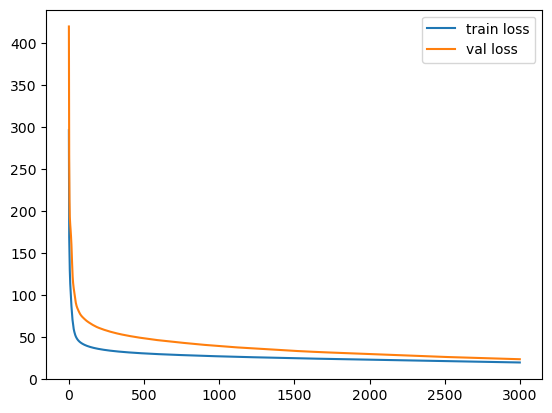

In [144]:
plot_history(history)

tensor(0.0771) tensor(0.9263)


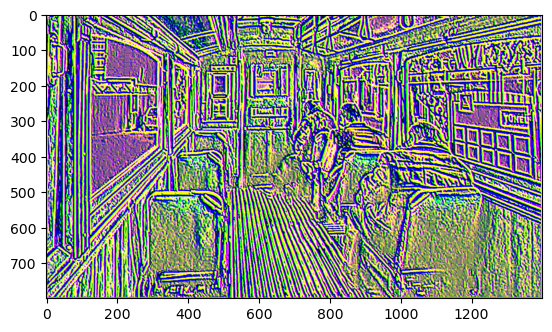

In [145]:
#test = images_lr[0]
test = read_image('out_before.png')
test = test[None, :]/255.
model_deblur.eval()
with torch.no_grad():
    preds = model_deblur(test)
preds = preds.detach().cpu()
img = preds[0].permute(1,2,0)
to_save = (preds[0]).cpu()
torchvision.utils.save_image(to_save, 'out.png')
plt.imshow(img)

ref = images_hr[0]
ref = ref[None, :]
ssim_after = ssim(preds, ref, data_range=1)
ssim_before = ssim(test, ref, data_range=1)
print(ssim_after, ssim_before)

In [132]:
test

tensor([[[[0.3098, 0.4353, 0.4863,  ..., 0.1961, 0.1843, 0.1255],
          [0.4157, 0.5255, 0.5608,  ..., 0.2235, 0.2353, 0.1922],
          [0.4431, 0.5216, 0.5529,  ..., 0.2196, 0.2353, 0.1922],
          ...,
          [0.8275, 0.9922, 0.9647,  ..., 0.2510, 0.2549, 0.2157],
          [0.7843, 0.9922, 0.9569,  ..., 0.2510, 0.2588, 0.2078],
          [0.5725, 0.8157, 0.7961,  ..., 0.2235, 0.2196, 0.1686]],

         [[0.2118, 0.2627, 0.3059,  ..., 0.1569, 0.1569, 0.1255],
          [0.2392, 0.2745, 0.2667,  ..., 0.1529, 0.1804, 0.1569],
          [0.2588, 0.2549, 0.2510,  ..., 0.1451, 0.1529, 0.1569],
          ...,
          [0.5725, 0.6078, 0.5569,  ..., 0.1608, 0.1647, 0.1608],
          [0.5216, 0.6549, 0.5765,  ..., 0.1725, 0.1804, 0.1608],
          [0.4431, 0.5412, 0.5608,  ..., 0.1843, 0.1529, 0.1216]],

         [[0.1451, 0.1765, 0.1804,  ..., 0.1451, 0.1333, 0.0941],
          [0.1490, 0.1529, 0.1686,  ..., 0.1529, 0.1647, 0.1412],
          [0.1843, 0.1529, 0.1686,  ..., 0

In [439]:
torch.save(model_deblur, 'ssim09282_1000epochs')
torch.save({
            'epoch': 1000,
            'model_state_dict': model_deblur.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion_deblur
            }, 'torch_ssim09282_1000epochs')

In [61]:
to_save

tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [0, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [1, 1, 0,  ..., 0, 0, 0],
         [1, 1, 0,  ..., 0, 0, 0],
         ...,
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0]]])

In [76]:
images_lr[0][0].numpy().shape

(400, 700)

In [79]:
lr = images_lr_downscales[0][0].numpy()
hr = images_hr[0][0].numpy()

gy, gx = np.gradient(lr)
gnorm = np.sqrt(gx**2 + gy**2)
print(np.average(gnorm))

gy, gx = np.gradient(hr)
gnorm = np.sqrt(gx**2 + gy**2)
print(np.average(gnorm))

21.01626905868889
10.95381203369981


In [88]:
lr = images_lr_downscales[0].type(torch.FloatTensor)
hr = images_hr[0].type(torch.FloatTensor)

gy, gx, gc = torch.gradient(lr)
gnorm = torch.sqrt(gx**2 + gy**2 + gc**2)
print(torch.mean(gnorm))

gy, gx, gc = np.gradient(hr)
gnorm = np.sqrt(gx**2 + gy**2 + gc**2)
print(np.average(gnorm))

tensor(40.4811)
34.710903


In [180]:
trainer.loss.grad

In [268]:
def dft_amp(img):
    fft_im = torch.fft.rfft( img, signal_ndim=2, onesided=False )
    fft_amp = fft_im[:,:,:,:,0]**2 + fft_im[:,:,:,:,1]**2
    return torch.sqrt(fft_amp)

dft_amp(images_lr[0])

TypeError: fft_rfft() got an unexpected keyword argument 'signal_ndim'

In [276]:
torch.fft.rfft(images_hr[0]).shape

torch.Size([3, 800, 701])

In [292]:
def tensor2freq(x):
    # crop image patches
    patch_factor = 1
    _, _, h, w = x.shape
    assert h % patch_factor == 0 and w % patch_factor == 0, (
        'Patch factor should be divisible by image height and width')
    patch_list = []
    patch_h = h // patch_factor
    patch_w = w // patch_factor
    for i in range(patch_factor):
        for j in range(patch_factor):
            patch_list.append(x[:, :, i * patch_h:(i + 1) * patch_h, j * patch_w:(j + 1) * patch_w])

        # stack to patch tensor
    y = torch.stack(patch_list, 1)

    # perform 2D DFT (real-to-complex, orthonormalization)
    freq = torch.fft.fft2(y, norm='ortho')
    freq = torch.stack([freq.real, freq.imag], -1)
    
    return freq.mean()


In [293]:
test = images_lr[0]
test = test[None, :]
tensor2freq(test)

tensor(0.0721)

In [4]:
def getSharpness(images):
    sharpness_vals = []
    derivative_imgs = []
    for img in images:
        derivative = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
        derivative_imgs.append(derivative)
        sharpness_vals.append(cv2.norm(derivative))
    return derivative_imgs, sharpness_vals

In [19]:
images_np = np.array(images_lr[0])
a, b = getSharpness(images_np)

In [42]:
b

[924742.4838478008, 804595.2767317243, 728193.959805353]

In [36]:
a

[array([[   0.,  908.,  760., ...,  150.,  136.,    0.],
        [   0.,  842.,  656., ...,  227.,  185.,    0.],
        [   0.,  751.,  504., ...,  409.,  316.,    0.],
        ...,
        [   0., -190., -472., ...,  -66.,  -76.,    0.],
        [   0., -343., -505., ...,  -78.,  -74.,    0.],
        [   0., -388., -478., ...,  -80.,  -66.,    0.]]),
 array([[   0.,  346.,   94., ...,  -16.,  -46.,    0.],
        [   0.,  362.,  129., ...,   20.,   -4.,    0.],
        [   0.,  410.,  196., ...,  150.,  141.,    0.],
        ...,
        [   0., -124., -482., ...,  -58.,  -70.,    0.],
        [   0., -283., -510., ...,  -72.,  -65.,    0.],
        [   0., -330., -486., ...,  -74.,  -54.,    0.]]),
 array([[   0.,  276.,   24., ...,   74.,  100.,    0.],
        [   0.,  278.,   15., ...,  134.,  152.,    0.],
        [   0.,  309.,   18., ...,  307.,  312.,    0.],
        ...,
        [   0., -101., -523., ...,  -69.,  -76.,    0.],
        [   0., -308., -626., ...,  -87.,  -9

In [18]:
torch_sobel = Sobel()

In [38]:
images_tensor = torch.FloatTensor(np.array(images_lr[:1]))
im_gr = torchvision.transforms.Grayscale()(images_tensor)
print(im_gr.shape)
derivs = torch_sobel(im_gr)
derivs

torch.Size([1, 1, 400, 700])


tensor([[[[124.3786,  65.1107,  70.5449,  ...,  55.6721,  64.9517,  68.5075],
          [110.8581,  22.6103,  26.8387,  ..., 168.0509, 195.4942, 243.8969],
          [119.5695,  33.0675,  40.2347,  ..., 320.4005, 336.0049, 361.7405],
          ...,
          [ 73.6868,  53.7021, 105.2892,  ...,   0.8454,   4.0844,  14.1444],
          [  1.1179,  93.7471, 108.4399,  ...,   2.1554,   7.5163,  18.8298],
          [ 91.5316, 105.1587,  86.2123,  ...,   9.7318,  11.0912,  16.1775]]]])

In [43]:
torch.linalg.norm(derivs)

tensor(165562.7188)

In [70]:
loss_sobel(images_tensor, None)

tensor(165562.7188, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


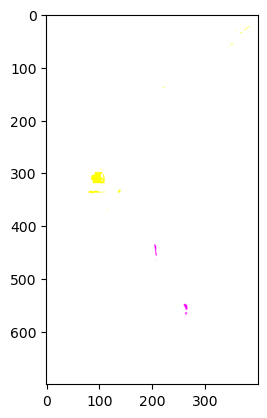

In [163]:
images_tensor = torch.FloatTensor(np.array(images_lr[0]))
blur = torchvision.transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.))(images_tensor)
plt.imshow(blur.T)
torchvision.utils.save_image(blur, 'test1_blur.png')

In [ ]:
class Sobel(nn.Module):
    def __init__(self):
        super().__init__()
        self.filter = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=0, bias=False)

        Gx = torch.tensor([[2.0, 0.0, -2.0], [4.0, 0.0, -4.0], [2.0, 0.0, -2.0]])
        Gy = torch.tensor([[2.0, 4.0, 2.0], [0.0, 0.0, 0.0], [-2.0, -4.0, -2.0]])
        G = torch.cat([Gx.unsqueeze(0), Gy.unsqueeze(0)], 0)
        G = G.unsqueeze(1)
        self.filter.weight = nn.Parameter(G, requires_grad=True)

    def forward(self, img):
        x = self.filter(img)
        x = torch.mul(x, x)
        x = torch.sum(x, dim=1, keepdim=True)
        x = torch.sqrt(x)
        return x
    
def loss_sobel(y_pred, y_true):
    torch_sobel = Sobel()
    grayscale = torchvision.transforms.Grayscale()(y_pred)
    out = torch.linalg.norm(torch_sobel(grayscale))
    print(out)
    return 1/out    

In [262]:
ignite.============

[tensor([[[[127, 145, 155,  ...,  50,  52,  53],
          [126, 141, 148,  ...,  55,  56,  57],
          [129, 141, 146,  ...,  69,  72,  75],
          ...,
          [242, 245, 240,  ...,  63,  62,  60],
          [245, 242, 236,  ...,  62,  62,  60],
          [240, 233, 230,  ...,  62,  62,  62]],

         [[ 65,  75,  77,  ...,  39,  39,  39],
          [ 60,  69,  71,  ...,  39,  38,  36],
          [ 57,  64,  67,  ...,  43,  43,  44],
          ...,
          [140, 145, 140,  ...,  41,  40,  38],
          [143, 141, 136,  ...,  41,  40,  39],
          [136, 131, 128,  ...,  41,  41,  42]],

         [[ 37,  44,  47,  ...,  36,  37,  39],
          [ 40,  48,  49,  ...,  33,  34,  34],
          [ 42,  49,  50,  ...,  35,  37,  40],
          ...,
          [ 32,  40,  36,  ...,  36,  34,  34],
          [ 39,  38,  33,  ...,  36,  35,  33],
          [ 39,  31,  27,  ...,  37,  36,  36]]]], dtype=torch.uint8), tensor([[[[127, 145, 155,  ...,  50,  52,  53],
          [126,